# Numerical Derivatives and Richardson Extrapolation

Numerical derivatives are used as the basis for many algorithms, but it is rare that we need to (or want to) take a numerical derivative on its own. This is due to the fact that we *can* take the derivative analytically for almost every function we encounter, if we need the numerical derivative of tabulated data we are often using interpolation also and can thus just take the derivative of the interpolated function, and taking the numerical derivative of noisy data must be done with care.

Though SciPy does contain a routine for calculating the $n^{\mathrm{th}}$ derivative of a function using center differencing (called `derivative` in `scipy.misc`) we will not be using it. Center differencing for first order derivatives is simple enough for us to use directly and we will focus on Richardson extrapolation in this example.

## Initialization

As always ....

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Globally fix plot styling
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

It is interesting to look at the documentation for np.misc.derivative and compare what it says compared to your version of scipy ....

In [ ]:
import scipy
print(scipy.__version__)
scipy.misc.derivative?

## Richardson Extrapolation

Richards extrapolation is a general approach to improve the accuracy of an algorithm. We will implement it for center differencing below, but it can be applied to a wide class of algorithms. In fact, we will see it again in the near future under the name "Romberg integration".

### General Discussion

Suppose we have an algorithm that calculates some quantity as a function of step size, $h$, to some accuracy $\mathcal{O}(h^p)$. We can think of this algorithm as a function of the step size, $F(h)$. To leading order we can write this function as
$$ F(h) = a_1 + \alpha_1 h^p + \mathcal{O}(h^r). $$
Here $a_1$ is the "true value" which we are looking for and $\alpha_1$ is an error that causes us to deviate from the true value. This error grows as $h^p$, that is, this is the leading order accuracy of our algorithm. Of course there are also other errors in our algorithm, these will grown in some other way which we specify as $h^r$ where $p<r$. Formally, the true value is just $a_1=F(0)$ so if we could evaluate $F(0)$ we would be done. Alternatively, if we can find an estimate for $a_1$ by any means we will have an estimate for the true value.

For Richardson extrapolation we notice that if we ignore the terms $\mathcal{O}(h^r)$ in the expression for $F(h)$ above then we have a linear equation in two parameters, $a_1$ and $\alpha_1$. Suppose we also know $F(h)$ for some other argument, then we would have two equations for two unknowns which we could solve. Let $q$ be some number and apply the algorithm for a step size $h/q$, in addition to the step size $h$. With this we then know $F(h)$ and $F(h/q)$, that is, we have the two equations we needed. Solving these equations we find
$$ a_1 = F(h) - \frac{F(h) - F(h/q)}{1-q^{-p}}. $$
This is our estimate for the true value.

Of course this estimate has an error that grows as $h^r$. What do we do? We apply Richardson extrapolation again. By repeatedly applying this procedure we can remove higher and higher order errors producing a more an more accurate result. (In principle, of course in practice a computer has limited precision so this will eventually fail.)

### Center Differencing

The general discussion is nice, but rather than continue talking in generalities let us look at a specific example to help make sense of the approach. For center differencing we calculate the derivative of a function, $f(x)$, at the point $x=z$ using
$$ f'(z) = \frac{f(z+h)-f(z-h)}{2h} + \mathcal{O}(h^2) + \mathcal{O}(h^4) + \cdots. $$
In the notation from above this means $p=2$ and $r=4$ and we can write our algorithm as a function of step size $h$ as
$$ F_1(h) = \frac{f(z+h)-f(z-h)}{2h}. $$
This estimates the first derivative with an error of $\mathcal{O}(h^2)$, so it has the form
$$ F_1(h) = a_1 + \alpha_1 h^2. $$

Although in principle any $q$ could be chosen, it is convenient to choose $q=2$ so that we evaluate $F_1(h)$ and $F_1(h/2)$ using the center differencing equation. This means that
$$ F_1\!\left( \frac{h}{2} \right) = \frac{f(z+h/2)-f(z-h/2)}{h}. $$
With these values we then get an estimate for the derivative as given in the general discussion,
$$ a_1 = F_1(h) - \frac{F_1(h)-F_1(h/2)}{1- 1/4} \equiv F_2(h). $$

As noted, we call this estimate $F_2(h)$ and we can improve it by again applying Richardson extrapolation. For center differencing we saw that our first estimate will have a residual error $\mathcal{O}(h^4)$. Thus we can write it as
$$ F_2(h) = a_2 + \alpha_2 h^4. $$
An estimate for $a_2$ is then given by
$$ a_2 = F_2(h) - \frac{F_2(h)-F_2(h/2)}{1-1/16} \equiv F_3(h). $$
We can then repeat the procedure on $F_3(h)$, *etc*. Notice that to calculate $F_3(h)$ we need $F_2(h/2)$, how do we calculate this? This is just another case of the general result we have been using,
$$ F_2(h/2) = F_1(h/2) - \frac{F_1(h/2)-F_1(h/4)}{1-1/4}. $$
Thus we really are constructing a table of values where the column to left in this table is combined to construct our new estimate:

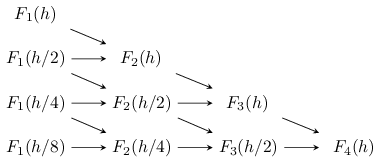

In this table the first column, the $F_1(h/2^n)$, are calculated using our algorithm (in this case center differencing). *All subsequent columns of the table are just simple algebraic combinations of elements from the previous column.* Thus, even if we have a complicated algorithm (unlike center differencing which is very simple and quick to calculate), we can easily improve the accuracy of our estimate. At each step the best estimate should be contained on the diagonal entries, $F_1(h)$ at the first step, $F_2(h)$ at the second step, *etc*.

## Implementation

Here is an implementation of Richardson extrapolation for center differencing. It sacrifices a little in efficiency for readability.

In [2]:
def richardson_center(f, z, h, nsteps, args=()):
    """Evaluate the first derivative of a function at z, that is f'(z),
    using Richardson extrapolation and center differencing.

    Returned is the full table of approximations, Fij for j <= i. The
    values of Fij for j > i are set to zero. The final value F[-1,-1]
    should be the most accurate estimate.

    Parameters
    ----------
    f : function
        Vectorized Python function.
        This is the function for which we are estimating the derivative.
    z : number
        Value at which to evaluate the derivative.
    h : number
        Initial stepsize.
    nsteps : integer
        Number of steps to perform.
    args : tuple, optional
        extra arguments to pass to the function, f.
    """
    # Extra check to allow for args=(1) to be handled properly. This is a
    # technical detail that you do not need to worry about.
    if not isinstance(args, (tuple, list, np.ndarray)):
        args = (args,)
    # Create a zero filled table for our estimates
    F = np.zeros((nsteps, nsteps))
    # First column of F is the center differencing estimate. We can fill this
    # without a loop!
    harr = h / 2.**np.arange(nsteps)
    F[:,0] = (f(z+harr, *args) - f(z-harr, *args)) / (2.*harr)
    # Now iterate, unfortunately we do need one loop. We could
    # get rid of the inner loop but the algorithm is a little easier to
    # understand if we do not.
    for i in range(1, nsteps):
        fact = 0.25
        for j in range(1, i+1):
            F[i,j] = F[i-1,j-1] - (F[i-1,j-1] - F[i,j-1]) / (1-fact)
            fact *= 0.25
    return F

## Example 1

As a test case consider the function
$$ f(x) = \mathrm{e}^{-x} \sin x$$
which has the derivative
$$ f'(x) = -f(x) + \mathrm{e}^{-x} \cos x.$$
We will calculate the derivative at $z=1$ using a step $h=0.9$.

In [3]:
# Define the function and its derivative
def f(x):
    return np.exp(-x) * np.sin(x)

def fderiv(x):
    return -f(x) + np.exp(-x) * np.cos(x)

In [4]:
# Set up conditions and use Richardson extrapolation.
z = 1.0
# As always we calculate the step size as a number that can be
# "exactly" represented numerically.
h10 = 0.9
h = h10 + z
h -= z
N = 6
F = richardson_center(f, z, h, N)
F

array([[ 0.02844655,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.07633703, -0.11126489,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.1022064 , -0.11082953, -0.11080051,  0.        ,  0.        ,
         0.        ],
       [-0.10864868, -0.1107961 , -0.11079387, -0.11079376,  0.        ,
         0.        ],
       [-0.1102576 , -0.11079391, -0.11079377, -0.11079377, -0.11079377,
         0.        ],
       [-0.11065973, -0.11079377, -0.11079377, -0.11079377, -0.11079377,
        -0.11079377]])

Notice that the result comes back in a two dimensional array. The first column constains the estimates from center differencing and the diagonal the improved estimates from Richardson extrapolation. We can easily access these elements of the array using array slicing and the `diag` function.

To more simply see the results we make a plot. Notice that Richardson extrapolation happened to get very close to the true value on the second step, $F_2(h)$.

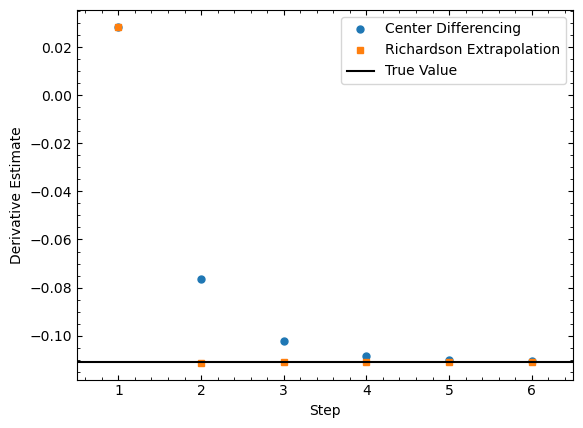

In [5]:
nstep = np.arange(N)+1
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(nstep, F[:,0], 'o', ms=5, label='Center Differencing')
ax.plot(nstep, np.diag(F), 's', ms=5, label='Richardson Extrapolation')
ax.axhline(fderiv(z), color='k', label='True Value')
ax.set_xlim(0.5, nstep[-1] + 0.5)
ax.legend(loc='best')
ax.set_xlabel('Step')
ax.set_ylabel('Derivative Estimate');

### Fractional Errors

From the above plot it is hard to gauge the improvements that Richardson extrapolation provide. Below we plot the fractional errors in the estimates.

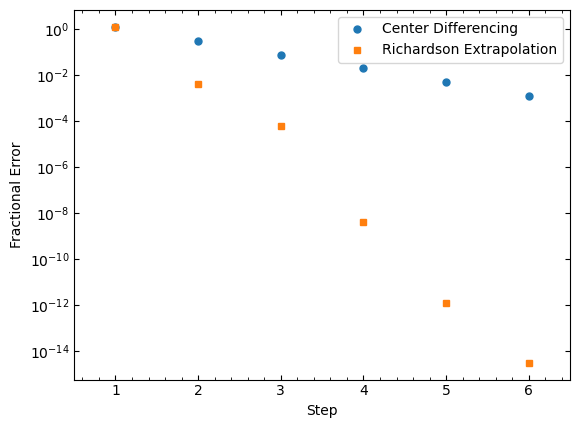

In [6]:
cd_err = np.abs(1 - F[:,0] / fderiv(z))
re_err = np.abs(1 - np.diag(F) / fderiv(z))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(nstep, cd_err, 'o', ms=5, label='Center Differencing')
ax.semilogy(nstep, re_err, 's', ms=5, label='Richardson Extrapolation')
ax.set_xlim(0.5, nstep[-1]+0.5)
ax.legend()
ax.set_xlabel('Step')
ax.set_ylabel('Fractional Error');

In general we see that Richardson extrapolation offers significant improvements! This is not always the case, but it is so simple to calculate that if we have gone through the trouble of calculating $F_1$ for various step sizes it would be silly to not combine them using Richardson extrapolation.

### Convergence Rate

In this case, and in test cases we consider, we know the true answer so can compare our result to it. In practice this is rarely the case, if we knew the true answer we would not need to perform the computation numerically! To deal with this we typically test our code on cases with known results, and then look for other ways to check the reasonableness of results for more complicated cases. One such test is to look at the convergence of our algorithm.

The diagonal elements in the table we get back from Richardson extrapolation should be better and better estimates as we move down along the diagonal. By taking the difference between these elements we get an estimate of the corrections made during each step of the algorithm. In other words, if we calculate $|F_{i-1,i-1}-F_{i,i}|$ we learn how large a change is made at the next step of Richardson extrapolation. If the algorithm is converging these values should get smaller and smaller, i.e., we should need to apply smaller and smaller corrections. This is **not an estimate in the computational error**, it instead shows how quickly our algorithm is settling down to a final value. There is not even a guarantee that this final value will be accurate. Even so, it is useful to compare this convergence rate to the absolute error as we will do below.

To calculate these differences we can use the `diff` function. Note that there is one fewer differences than there are elements in the array. We will again use array slicing to make plotting the results easy.

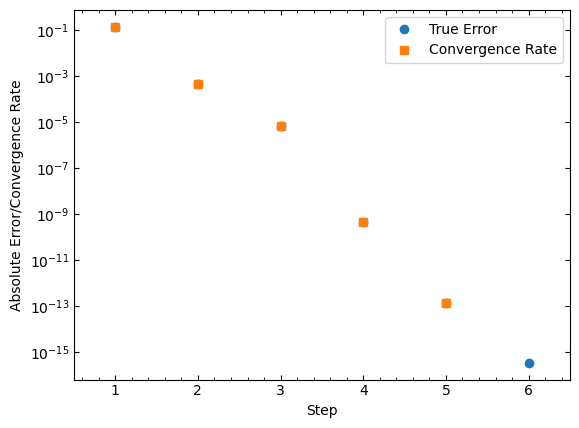

In [7]:
re_abserr = np.abs(np.diag(F) - fderiv(z))
re_convergence = np.abs(np.diff(np.diag(F)))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(nstep, re_abserr, 'o', label='True Error')
ax.semilogy(nstep[:-1], re_convergence, 's', label='Convergence Rate')
ax.set_xlim(0.5, nstep[-1] + 0.5)
ax.legend()
ax.set_xlabel('Step')
ax.set_ylabel('Absolute Error/Convergence Rate');

We see that for this function the convergence rate gives a very good estimate of the absolute error. This is **not always** the case.

## Example 2

As another example we will consider the derivative of the gamma function. The gamma function is one example of the many special functions we encounter in physics. It is a particularly interesting function, it is the generalization of the factorial. We are familiar with calculating the factorial of an integer, $n!$. The gamma function generalizes this to arbitrary numbers, including both negative and complex numbers. For a nonnegative integer $n! = \Gamma(n+1)$.

A large collection of special functions is contained in `scipy.special`. We will encounter a number of them throughout the semester (including in the lab this week).

For the purposes of this example we will just consider the derivative of the gamma function,
$$ f(x) = \Gamma(x) $$
evaluated at $z=-0.6$ using a step of $h=0.9$. It turns out that the derivative of the gamma function is also another special function. Actually, the derivative of the log of the gamma function is known as the digamma function, $\psi(x)$, so that
$$ f'(x) = \Gamma(x) \psi(x). $$

In [8]:
# Normally this would be done with the rest of the initialization above, but,
# import the special functions and give them a short name.
import scipy.special as sf

In [9]:
# Define the function and its derivative.
def f(x):
    return sf.gamma(x)

def fderiv(x):
    return f(x) * sf.digamma(x)

In [10]:
# Set up conditions and use Richardson extrapolation.
z = -0.6
h10 = 0.9
h = h10 + z
h -= z
N = 6
F = richardson_center(f, z, h, N)
F

array([[  0.34905399,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [-30.07032011, -40.21011147,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  5.73980053,  17.67650742,  21.53561534,   0.        ,
          0.        ,   0.        ],
       [  3.74182426,   3.07583217,   2.10245382,   1.79399093,
          0.        ,   0.        ],
       [  3.40879194,   3.29778116,   3.31257776,   3.33178608,
          3.33781665,   0.        ],
       [  3.33255269,   3.3071396 ,   3.3077635 ,   3.30768708,
          3.30759258,   3.30756303]])

Plot the center differencing and Richardson extrapolation estimates. Notice that Richardson extrapolation is **not always** better. This is a common problem with numerical work, there is no guarantee that a more sophisticated algorithm will always produce more accurate results!

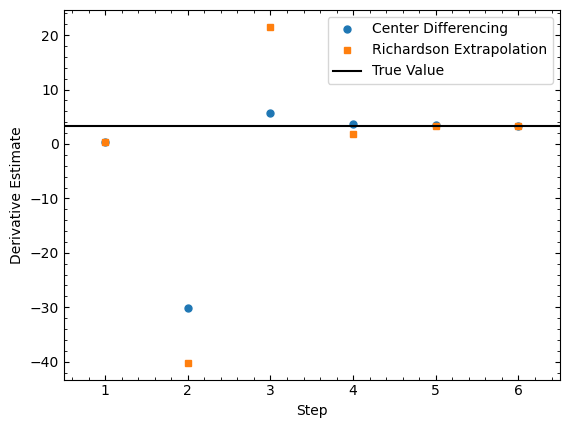

In [11]:
nstep = np.arange(N) + 1
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(nstep, F[:,0], 'o', ms=5, label='Center Differencing')
ax.plot(nstep, np.diag(F), 's', ms=5, label='Richardson Extrapolation')
ax.axhline(fderiv(z), color='k', label='True Value')
ax.set_xlim(0.5, nstep[-1] + 0.5)
ax.legend(loc='best')
ax.set_xlabel('Step')
ax.set_ylabel('Derivative Estimate');

To see this more clearly plot the fractional errors. Notice that at step 5 Richard extrapolation does produce a more accurate result. (What should happen if we were to use more steps?)

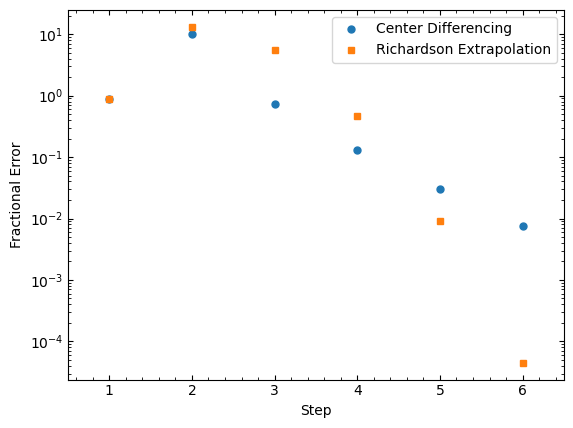

In [12]:
cd_err = np.abs(1 - F[:,0] / fderiv(z))
re_err = np.abs(1 - np.diag(F) / fderiv(z))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(nstep, cd_err, 'o', ms=5, label='Center Differencing')
ax.semilogy(nstep, re_err, 's', ms=5, label='Richardson Extrapolation')
ax.set_xlim(0.5, nstep[-1] + 0.5)
ax.legend()
ax.set_xlabel('Step')
ax.set_ylabel('Fractional Error');

Again we look at the convergence rate.

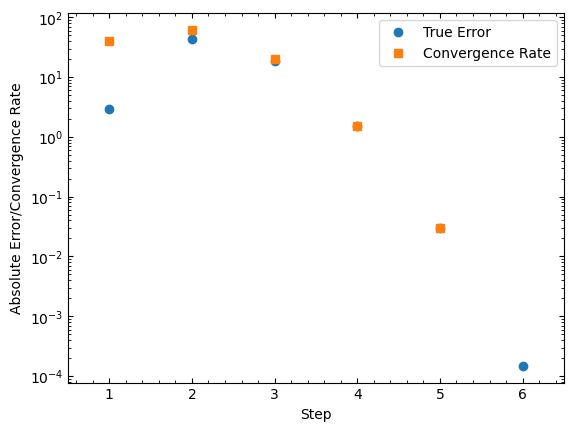

In [13]:
re_abserr = np.abs(np.diag(F) - fderiv(z))
re_convergence = np.abs(np.diff(np.diag(F)))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(nstep, re_abserr, 'o', label='True Error')
ax.semilogy(nstep[:-1], re_convergence, 's', label='Convergence Rate')
ax.set_xlim(0.5, nstep[-1] + 0.5)
ax.legend()
ax.set_xlabel('Step')
ax.set_ylabel('Absolute Error/Convergence Rate');

Does this look like it has converged? Do we believe that the algorithm has converged? In this case, probably. It does seem to be converging, but we really should run it for a few more steps to see that the convergence rate does continue to decrease.